# Regularized logistic regression



In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt

# Optimization module in scipy
from scipy import optimize

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## Data


In [2]:
# Load data
# The first two columns contains the exam scores and the third column
# contains the label.
data = np.loadtxt(os.path.join('Data', 'ex2data1.txt'), delimiter=',')
X, y = data[:, 0:2], data[:, 2]

In [3]:
data[:5]

array([[34.62365962, 78.02469282,  0.        ],
       [30.28671077, 43.89499752,  0.        ],
       [35.84740877, 72.90219803,  0.        ],
       [60.18259939, 86.3085521 ,  1.        ],
       [79.03273605, 75.34437644,  1.        ]])

###  Visualizing the data


In [4]:
def plotData(X, y):
    
    pos = y == 1
    neg = y == 0
    # Create New Figure
    fig = plt.figure()

    plt.plot(X[pos, 0], X[pos, 1], 'k*', lw=2, ms=10)
    plt.plot(X[neg, 0], X[neg, 1], 'ko', mfc='y', ms=8, mec='k', mew=1)


Now, we call the implemented function to display the loaded data:

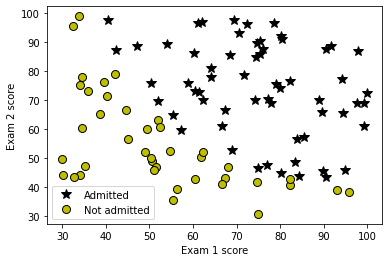

In [5]:
plotData(X, y)
# add axes labels
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend(['Admitted', 'Not admitted'])
pass

In [6]:
# Setup the data matrix appropriately, and add ones for the intercept term
m, n = X.shape

# Add intercept term to X
X = np.concatenate([np.ones((m, 1)), X], axis=1)

<a id="section1"></a>
### 1.2 Sigmoid


The logistic regression hypothesis is defined as:

$$ h_\theta(x) = g(\theta^T x)$$

where function $g$ is the sigmoid function. The sigmoid function is defined as: 

$$g(z) = \frac{1}{1+e^{-z}}$$.


In [7]:
def sigmoid(z):
    # convert input to a numpy array
    z = np.array(z)

    return 1.0 / (1. + np.exp(-z))

<a id="section5"></a>
### 2.3 Cost function and gradient

Now you will implement code to compute the cost function and gradient for regularized logistic regression. Complete the code for the function `costFunctionReg` below to return the cost and gradient.

Recall that the regularized cost function in logistic regression is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)}\log \left( h_\theta \left(x^{(i)} \right) \right) - \left( 1 - y^{(i)} \right) \log \left( 1 - h_\theta \left( x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Note that you should not regularize the parameters $\theta_0$. The gradient of the cost function is a vector where the $j^{th}$ element is defined as follows:

$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \qquad \text{for } j =0 $$

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m}\theta_j \qquad \text{for } j \ge 1 $$
<a id="costFunctionReg"></a>

In [8]:
def costFunctionReg(theta, X, y, lambda_):
    """
    Compute cost and gradient for logistic regression with regularization.
    
    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is 
        the number of features including any intercept. If we have mapped
        our initial features into polynomial features, then n is the total 
        number of polynomial features. 
    
    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (after feature mapping).
    
    y : array_like
        The data labels. A vector with shape (m, ).
    
    lambda_ : float
        The regularization parameter. 
    
    Returns
    -------
    J : float
        The computed value for the regularized cost function. 
    
    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
    
    Instructions
    ------------
    Compute the cost `J` of a particular choice of theta.
    Compute the partial derivatives and set `grad` to the partial
    derivatives of the cost w.r.t. each parameter in theta.
    """
    
    if y.dtype == bool:
        y = y.astype(int)
        
    # Initialize some useful values
    m = y.size  # number of training examples

    # You need to return the following variables correctly 
    J = 0
    grad = np.zeros(theta.shape)

    h = sigmoid(np.dot(X, theta))
    J = np.mean((-y * np.log(h)) - ((1-y) * np.log(1 - h)))
    
    temp = theta.copy()
    temp[0] = 0
    J_regularization = (lambda_ / (2*m)) * np.dot(temp.T, temp)
    J = J + J_regularization
    
    grad = (1/m) * (X.T @ (h - y))
    grad = grad + (lambda_ / m) * temp
        
    return J, grad

#### 1.2.3 Learning parameters using `scipy.optimize`

In the previous assignment, you found the optimal parameters of a linear regression model by implementing gradient descent. You wrote a cost function and calculated its gradient, then took a gradient descent step accordingly. This time, instead of taking gradient descent steps, you will use the [`scipy.optimize` module](https://docs.scipy.org/doc/scipy/reference/optimize.html). SciPy is a numerical computing library for `python`. It provides an optimization module for root finding and minimization. As of `scipy 1.0`, the function `scipy.optimize.minimize` is the method to use for optimization problems(both constrained and unconstrained).

For logistic regression, you want to optimize the cost function $J(\theta)$ with parameters $\theta$.
Concretely, you are going to use `optimize.minimize` to find the best parameters $\theta$ for the logistic regression cost function, given a fixed dataset (of X and y values). You will pass to `optimize.minimize` the following inputs:


In [9]:
def predict(theta, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression.
    Computes the predictions for X using a threshold at 0.5 
    (i.e., if sigmoid(theta.T*x) >= 0.5, predict 1)
    """
   
    m = X.shape[0] # Number of training examples

    # You need to return the following variables correctly
    p = np.zeros(m)

    pred_prob = np.dot(X, theta)
    
    p = (pred_prob > 0.5) + 0 ## add zero to convert T/F to int
    
    return p

/Users/billy/Documents/GitHub/ML-AndrewNG-python/2_LogisticRegression/utils.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(out)


Train Accuracy: 79.7 %
Expected accuracy (with lambda = 1): 83.1 % (approx)



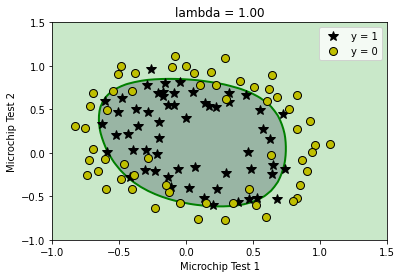

In [31]:
# Initialize fitting parameters
initial_theta = np.zeros(X.shape[1])

# Set regularization parameter lambda to 1 (you should vary this)
lambda_ = 1

# set options for optimize.minimize
options= {'maxiter': 100}

res = optimize.minimize(costFunctionReg,
                        initial_theta,
                        (X, y, lambda_),
                        jac=True,
                        method='TNC',
                        options=options)

# the fun property of OptimizeResult object returns
# the value of costFunction at optimized theta
cost = res.fun

# the optimized theta is in the x property of the result
theta = res.x

utils.plotDecisionBoundary(plotData, theta, X, y)
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend(['y = 1', 'y = 0'])
plt.grid(False)
plt.title('lambda = %0.2f' % lambda_)

# Compute accuracy on our training set
p = predict(theta, X)

print('Train Accuracy: %.1f %%' % (np.mean(p == y) * 100))
print('Expected accuracy (with lambda = 1): 83.1 % (approx)\n')


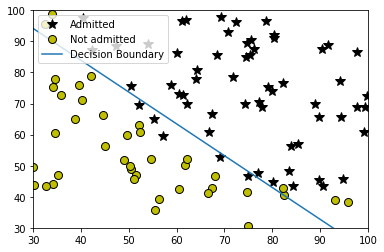

In [11]:
# Plot Boundary
utils.plotDecisionBoundary(plotData, theta, X, y)

### Non linear hypothesis

In [12]:
# Load Data
# The first two columns contains the X values and the third column
# contains the label (y).
data = np.loadtxt(os.path.join('Data', 'ex2data2.txt'), delimiter=',')
X = data[:, :2]
y = data[:, 2]

In [13]:
data[:5]

array([[ 0.051267,  0.69956 ,  1.      ],
       [-0.092742,  0.68494 ,  1.      ],
       [-0.21371 ,  0.69225 ,  1.      ],
       [-0.375   ,  0.50219 ,  1.      ],
       [-0.51325 ,  0.46564 ,  1.      ]])

### 2.1 Visualize the data

Similar to the previous parts of this exercise, `plotData` is used to generate a figure, where the axes are the two test scores, and the positive (y = 1, accepted) and negative (y = 0, rejected) examples are shown with
different markers.

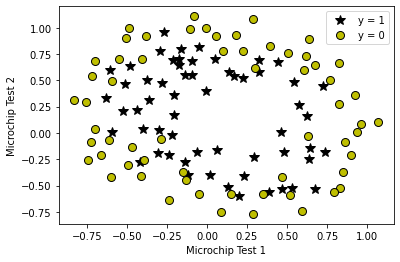

In [14]:
plotData(X, y)
# Labels and Legend
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')

# Specified in plot order
plt.legend(['y = 1', 'y = 0'], loc='upper right')
pass

The above figure shows that our dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straight-forward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.

### 2.2 Feature mapping

One way to fit the data better is to create more features from each data point. In the function `mapFeature` defined in the file `utils.py`, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

$$ \text{mapFeature}(x) = \begin{bmatrix} 1 & x_1 & x_2 & x_1^2 & x_1 x_2 & x_2^2 & x_1^3 & \dots & x_1 x_2^5 & x_2^6 \end{bmatrix}^T $$

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.
While the feature mapping allows us to build a more expressive classifier, it also more susceptible to overfitting. In the next parts of the exercise, you will implement regularized logistic regression to fit the data and also see for yourself how regularization can help combat the overfitting problem.


In [15]:
# Note that mapFeature also adds a column of ones for us, so the intercept
# term is handled
X = utils.mapFeature(X[:, 0], X[:, 1])

In [16]:
X.shape

(118, 28)

/Users/billy/Documents/GitHub/ML-AndrewNG-python/2_LogisticRegression/utils.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(out)


Train Accuracy: 79.7 %


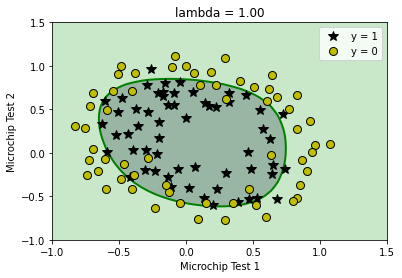

In [17]:
# Initialize fitting parameters
initial_theta = np.zeros(X.shape[1])

# Set regularization parameter lambda to 1 (you should vary this)
lambda_ = 1

# set options for optimize.minimize
options= {'maxiter': 100}

res = optimize.minimize(costFunctionReg,
                        initial_theta,
                        (X, y, lambda_),
                        jac=True,
                        method='TNC',
                        options=options)

# the fun property of OptimizeResult object returns
# the value of costFunction at optimized theta
cost = res.fun

# the optimized theta is in the x property of the result
theta = res.x

utils.plotDecisionBoundary(plotData, theta, X, y)
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend(['y = 1', 'y = 0'])
plt.grid(False)
plt.title('lambda = %0.2f' % lambda_)

# Compute accuracy on our training set
p = predict(theta, X)

print('Train Accuracy: %.1f %%' % (np.mean(p == y) * 100))

## Multiclass 

#### One vs All

Note that in multi-class we cannot not visualize in 2D as before

In [32]:
def oneVsAll(X, y, num_labels, lambda_):
    """
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n). m is the number of 
        data points, and n is the number of features. 
    
    y : array_like
        The data labels. A vector of shape (m, ).
    
    num_labels : int
        Number of possible labels.
    
    lambda_ : float
        The logistic regularization parameter.
    
    Returns
    -------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        (ie. `numlabels`) and n is number of features without the bias.
    
    Note
    ----
    we recommend using `scipy.optimize.minimize(method='CG')`
    to optimize the cost function. It is okay to use a for-loop 
    (`for c in range(num_labels):`) to loop over the different classes.
       
    """
    # Some useful variables
    m, n = X.shape
    
    # You need to return the following variables correctly 
    all_theta = np.ones((num_labels, n + 1))

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # ====================== YOUR CODE HERE ======================
    initial_theta = np.zeros(n + 1)
    options = {'maxiter': 50}

    for c in range(num_labels):
        res = optimize.minimize(costFunctionReg, 
                                initial_theta, 
                                (X, (y == c), lambda_), 
                                jac=True, 
                                method='CG',
                                options=options) 
        
        all_theta[c, :] = res.x

    # ============================================================
    return all_theta

In [19]:
def predictOneVsAll(all_theta, X):
   
    
    m = X.shape[0];
    num_labels = all_theta.shape[0]

    # You need to return the following variables correctly 
    p = np.zeros(m)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    pred = sigmoid(np.dot(X, all_theta.T))
    
    p = np.argmax(pred[:, :], axis=1)

    return p

In [20]:
lambda_ = 1
all_theta = oneVsAll(X, y, 2, lambda_)

In [21]:
pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy: {:.2f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 83.05%


## Just Billy

In [22]:
def gradientDescent(X,y,theta,alpha,num_iters,Lambda):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    
    m=len(y)
    J_history = []
    
    for i in range(num_iters):
        cost, grad = costFunctionReg(theta, X, y, Lambda)
        theta = theta - (alpha * grad)  # (1 - (alpha*Lambda)/m) reg term
        J_history.append(cost)
    
    return theta , J_history

In [28]:
theta , J_history = gradientDescent(X, y, initial_theta, 1, 500, 0)

Text(0.5, 1.0, 'Cost function using Gradient Descent')

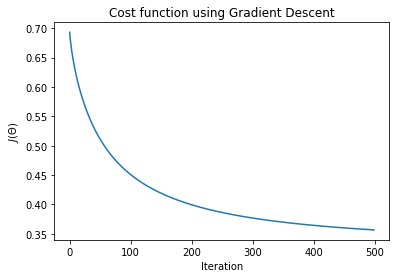

In [29]:
plt.plot(J_history)
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

In [30]:
print("Train Accuracy:", round((predict(theta, X) == y).mean() *100 , 3),"%")

Train Accuracy: 81.356 %


## Gradient Checking

In [26]:
def computeNumericalGradient(J, theta, e=1e-4):
    """
    Computes the gradient using "finite differences" and gives us a numerical estimate of the
    gradient.

    Parameters
    ----------
    J : func
        The cost function which will be used to estimate its numerical gradient.

    theta : array_like
        The one dimensional unrolled network parameters. The numerical gradient is computed at
         those given parameters.

    e : float (optional)
        The value to use for epsilon for computing the finite difference.

    Notes
    -----
    The following code implements numerical gradient checking, and
    returns the numerical gradient. It sets `numgrad[i]` to (a numerical
    approximation of) the partial derivative of J with respect to the
    i-th input argument, evaluated at theta. (i.e., `numgrad[i]` should
    be the (approximately) the partial derivative of J with respect
    to theta[i].)
    """
    numgrad = np.zeros(theta.shape)
    perturb = np.diag(e * np.ones(theta.shape))
    for i in range(theta.size):
        loss1, _ = J(theta - perturb[:, i])
        loss2, _ = J(theta + perturb[:, i])
        numgrad[i] = (loss2 - loss1)/(2*e)
    return numgrad

In [27]:
## create short hand
costFunc = lambda p: costFunctionReg(p, X, y, lambda_)

## compute theoritical grads
numgrad = computeNumericalGradient(costFunc, theta, e=1e-4)

## compute real grads
cost, grad = costFunc(theta)


diff = np.linalg.norm(numgrad - grad)/np.linalg.norm(numgrad + grad)

print('If your backpropagation implementation is correct, then \n'
          'the relative difference will be small (less than 1e-9). \n'
          'Relative Difference: %g' % diff)

If your backpropagation implementation is correct, then 
the relative difference will be small (less than 1e-9). 
Relative Difference: 1.33701e-07
